### RANDOM FOREST MODEL

In [1]:
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt

In [2]:
def load_data(years = ['2013','2014','2015']):
    file_name_1 = 'elspot-prices_'
    file_name_2 = '_hourly_dkk.csv'
    data_folder = os.getcwd().replace('notebook','data\\')
    all_data=[]
    for year in years:
        file_name_tot = data_folder + file_name_1 + year + file_name_2
        all_data.append(pd.read_csv(file_name_tot,encoding = "ISO-8859-1",sep=';',decimal=','))
    df = pd.concat(all_data, ignore_index=True,sort= True)
    return df
    

In [4]:
def generate_shifted_features(df,time_shift,colname):
    pd.options.mode.chained_assignment = None
    df = df[['datetime','Hours','Bergen']]
    for t in time_shift:
        df.loc[:,colname+'_'+str(t)] = df.Bergen.shift(t)
    return df

In [6]:
def generate_calendar_features(df):
    
    df['Month'] = df['datetime'].apply(lambda x: np.int(x[3:5]))
    df['Hour'] = df['Hours'].apply(lambda x: np.int(x[0:2]))
    df = pd.concat([df,pd.get_dummies(df['Month'],prefix='month'),pd.get_dummies(df['Hour'],prefix='hour')],axis=1)
    df = df.drop(['Month','month_12','Hours','Hour','hour_0'],axis=1)
    
    return df

In [8]:
def create_train_test(df,test_size = 8000):
    df = df.dropna()
    train_size = df.shape[0]-test_size
    
    X_train = df.drop(['Bergen','datetime'],axis=1).head(train_size)
    y_train = df['Bergen'].head(train_size)
    X_test = df.drop(['Bergen','datetime'],axis=1).tail(test_size)
    y_test = df['Bergen'].tail(test_size)
    
    return X_train, y_train, X_test, y_test
    

In [43]:
def gridsearch_rf(rf, X_train = X_train, y_train = y_train, param_grid = param_grid, n_jobs = -1):
    cv = KFold(4)
    scorer = make_scorer(mean_absolute_error)
    rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, cv = cv, scoring = scorer, verbose=2, n_jobs = n_jobs)
    rf_grid.fit(X_train, y_train)
    model = rf_grid.best_estimator_
    return model

In [16]:
def predict_model(model = model,X_test = X_test,y_test = y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test,y_pred)
    rmse = sqrt(mean_squared_error(y_test,y_pred))
    print('MAE = {:.2f}, RMSE = {:.2f}'.format(mae,rmse))
    return y_pred,mae,rmse
    

In [18]:
def plot_predictions(y_test = y_test, y_pred = y_pred,plot_samples=100,size=(15,5)):
    plt.figure(figsize=size)
    plt.title('Example of model predictions')
    plt.scatter(range(plot_samples),y_test[:plot_samples],color='b')
    plt.scatter(range(plot_samples),y_pred[:plot_samples],color='r')
    plt.show()
    return

In [3]:
df = load_data()
time_shift = [1,3,6,9,12,24,36,48,60]
df_bergen = generate_shifted_features(df,time_shift,'Bergen')
df_bergen = generate_calendar_features(df_bergen)
X_train, y_train, X_test, y_test = create_train_test(df_bergen,test_size = 8000)

,Bergen,DK1,DK2,EE,ELE,FI,FRE,Hours,Kr.sand,LT,...,Molde,Oslo,SE1,SE2,SE3,SE4,SYS,Tr.heim,Tromsø,datetime
0,246.01,104.66,104.66,232.14,232.14,231.54,NaN,00 - 01,246.01,182.16,...,231.54,246.01,231.54,231.54,231.54,231.54,231.62,231.54,231.54,01/01/2013
1,245.94,82.50,82.50,228.34,228.34,205.21,NaN,01 - 02,245.94,176.19,...,229.83,245.94,205.21,205.21,205.21,205.21,227.29,229.83,229.83,01/01/2013
2,243.11,63.41,63.41,182.31,182.31,182.31,NaN,02 - 03,243.11,178.51,...,229.53,243.11,182.31,182.31,182.31,182.31,215.73,229.53,229.53,01/01/2013
3,235.20,0.75,0.75,162.69,162.69,162.69,NaN,03 - 04,235.20,177.91,...,229.08,235.20,162.69,162.69,162.69,162.69,207.97,229.08,229.08,01/01/2013
4,227.81,14.99,14.99,166.87,166.87,166.87,NaN,04 - 05,227.81,173.51,...,228.48,227.81,166.87,166.87,166.87,166.87,201.11,228.48,228.48,01/01/2013


In [10]:
# Number of trees in random forest
n_estimators = [5,10,30]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [3,6,9]
# Minimum number of samples required to split a node
min_samples_split = [2,4, 8]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [12]:
# Number of trees in random forest
base_estimator = [DecisionTreeRegressor(max_depth=15)]
base_estimator = [RandomForestRegressor()]
n_estimators = [5,10,20,30]
# Number of features to consider at every split
learning_rate = [0.1,0.5,0.75,1]
# Maximum number of levels in tree
loss = ['linear','square','exponential']
# Create the random grid
param_grid = {'base_estimator': base_estimator,
              'n_estimators': n_estimators,
              'learning_rate': learning_rate,
              'loss': loss}

In [14]:
model = gridsearch_rf(AdaBoostRegressor(),n_jobs = 6)

Fitting 4 folds for each of 48 candidates, totalling 192 fits


[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 192 out of 192 | elapsed: 16.6min finished


In [15]:
print(model)

AdaBoostRegressor(base_estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
         learning_rate=0.75, loss='square', n_estimators=5,
         random_state=None)


In [17]:
y_pred, mae, rmse = predict_model()

MAE = 5.35, RMSE = 11.52


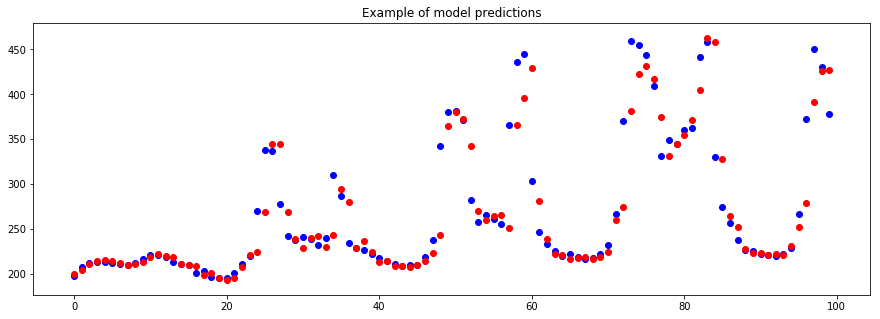

In [19]:
plot_predictions()

### FEATURE IMPORTANCE AND FEATURE SELECTION

In [48]:
def plot_importance():
    features = X_train.columns.values
    importances = model.feature_importances_
    indices = np.argsort(importances)
    plt.figure(figsize=(5,5))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

In [40]:
def select_top_features(X_train, X_test,top_k = 10):
    features = X_train.columns.values
    importances = model.feature_importances_
    indices = np.argsort(importances)
    indices_top_k = indices[::-1][:top_k]
    features_top_k = features[indices_top_k]
    X_train = X_train[features_top_k]
    X_test = X_test[features_top_k]
    return X_train, X_test

In [41]:
X_train, X_test = select_top_features(X_train, X_test,top_k = 10)

In [44]:
model = gridsearch_rf(AdaBoostRegressor(),n_jobs = 8)

Fitting 4 folds for each of 48 candidates, totalling 192 fits


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  5.1min
[Parallel(n_jobs=8)]: Done 192 out of 192 | elapsed:  6.6min finished


In [45]:
y_pred, mae, rmse = predict_model()

MAE = 5.35, RMSE = 11.52


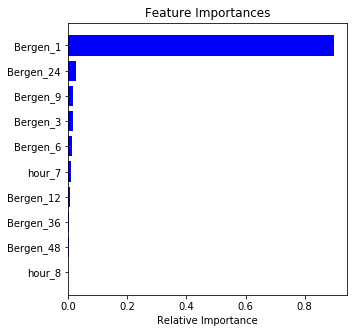

In [49]:
plot_importance()